## Creates reports for all users

In [1]:
%matplotlib inline


from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

import datetime

#from pylab import figure, axes, pie, title, show

import math
import matplotlib.pyplot as plt
#import matplotlib.mlab as mlab
from matplotlib import gridspec
import numpy as np
import pandas as pd
import networkx as nx

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)

### Set interval 

In [2]:
cdt = datetime.datetime.utcnow() #cdt = datetime.datetime(2017,1,21,9,0,0)

GT = (cdt - datetime.timedelta(hours=7*24)).strftime("%Y%m%dT%H%m%S+0000")
LT = cdt.strftime("%Y%m%dT%H%m%S+0000")
print('between: ', GT, ' and ', LT)

between:  20170309T100315+0000  and  20170316T100315+0000


### find indices to query

In [3]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = [x for x in indices if x != '']
indices = [x.strip() for x in indices]

ind=[]
for n in range(0,9):
    pday  = cdt - datetime.timedelta(days=n)
    i='jobs_archive_%d-%02d-%02d' % (pday.year, pday.month, pday.day)
    if i in indices: ind.append(i)

print(ind)

['jobs_archive_2017-03-16', 'jobs_archive_2017-03-15', 'jobs_archive_2017-03-14', 'jobs_archive_2017-03-13', 'jobs_archive_2017-03-12', 'jobs_archive_2017-03-11', 'jobs_archive_2017-03-10', 'jobs_archive_2017-03-09', 'jobs_archive_2017-03-08']


## Get the data from Elasticsearch, and store the record based on its type

In [4]:
my_query = {
  'size': 0,
  'query':{
    'bool':{
      'must' : [
        {'term':{'prodsourcelabel':'user'}}
      ]
    }
  },
  "aggs" : {
    "user" : {
      "terms" : { "field" : "produserid", "size": 2 },
      "aggs" : {
        "jobstatus" : {
          "terms" : {"field" : "jobstatus", "size": 5},
          "aggs" : {
            "walltime" : { "sum" :{"field" : "wall_time"} },
            "cputime" : { "sum" :{"field" : "cpuconsumptiontime"} }
          }
        },
        "priority":{"avg" :{"field" : "currentpriority"}}
      }
    },
    "tot_walltime" : { "sum" :{"field" : "wall_time"} },
    "tot_cputime" : { "sum" :{"field" : "cpuconsumptiontime"} },
    "tot_priority": {"avg" :{"field" : "currentpriority"} }
  }
}

#execute query
res = es.search(index=ind, body=my_query, request_timeout=120)
res=res['aggregations']
print(res)



{'tot_walltime': {'value': 18601514645.0}, 'user': {'buckets': [{'jobstatus': {'buckets': [{'cputime': {'value': 97133.0}, 'key': 'closed', 'walltime': {'value': 63005.0}, 'doc_count': 4408264}, {'cputime': {'value': 52878473.0}, 'key': 'finished', 'walltime': {'value': 73641251.0}, 'doc_count': 99884}, {'cputime': {'value': 24591889.0}, 'key': 'failed', 'walltime': {'value': 29006595.0}, 'doc_count': 5914}, {'cputime': {'value': 0.0}, 'key': 'cancelled', 'walltime': {'value': 0.0}, 'doc_count': 1075}], 'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0}, 'key': '/DC=ch/DC=cern/OU=Organic Units/OU=Users/CN=caminal/CN=711184/CN=Roger Caminal Armadans/CN=proxy', 'priority': {'value': -67152.63562545278}, 'doc_count': 4515137}, {'jobstatus': {'buckets': [{'cputime': {'value': 27439.0}, 'key': 'closed', 'walltime': {'value': 1.0}, 'doc_count': 1139866}, {'cputime': {'value': 543594765.0}, 'key': 'finished', 'walltime': {'value': 1017114530.0}, 'doc_count': 228880}, {'cputime': {'va

### usefull functions

In [5]:
def parseUname(FN):
    #print(FN)
    unW=FN.lstrip('/').replace('/CN=proxy','').split('/')
    #extract all CN= that are not a number
    CNs=[]
    for i in unW:
        if i[:3]=='CN=': 
            i=i[3:]
            if not i.isdigit(): 
                CNs.append(i)
    if len(CNs)==1:
        return CNs[0]
    for un in CNs:
        if un.count(' ')==0:
            return un

### creating plots

caminal 4515137 -67152.63562545278
[{'cputime': {'value': 97133.0}, 'key': 'closed', 'walltime': {'value': 63005.0}, 'doc_count': 4408264}, {'cputime': {'value': 52878473.0}, 'key': 'finished', 'walltime': {'value': 73641251.0}, 'doc_count': 99884}, {'cputime': {'value': 24591889.0}, 'key': 'failed', 'walltime': {'value': 29006595.0}, 'doc_count': 5914}, {'cputime': {'value': 0.0}, 'key': 'cancelled', 'walltime': {'value': 0.0}, 'doc_count': 1075}]
{'cputime': {'value': 97133.0}, 'key': 'closed', 'walltime': {'value': 63005.0}, 'doc_count': 4408264}
{'cputime': {'value': 52878473.0}, 'key': 'finished', 'walltime': {'value': 73641251.0}, 'doc_count': 99884}
{'cputime': {'value': 24591889.0}, 'key': 'failed', 'walltime': {'value': 29006595.0}, 'doc_count': 5914}
{'cputime': {'value': 0.0}, 'key': 'cancelled', 'walltime': {'value': 0.0}, 'doc_count': 1075}


NameError: name 'title' is not defined

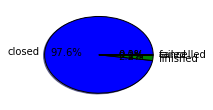

In [6]:
tot_walltime=res['tot_walltime']['value']
tot_cputime=res['tot_cputime']['value']
tot_priority=res['tot_priority']['value']

users=res['user']['buckets']
for u in users:
    uname = parseUname(u['key'])
    ujobs=u['doc_count']
    upriority=u['priority']['value']
    print (uname, ujobs, upriority)
    jobstatus=u['jobstatus']['buckets']
    print(jobstatus)
    #print(u)
    jskey=[]
    jscount=[]
    jscpu=[]
    jswall=[]
    sumwall=0
    sumcpu=0
    sumjobs=0
    for js in jobstatus:
        print(js)
        jskey.append(js['key'])
        jscount.append(js['doc_count'])
        jscpu.append(js['cputime']['value'])
        jswall.append(js['walltime']['value'])
        sumjobs+=js['doc_count']
        sumwall+=js['walltime']['value']
        sumcpu +=js['cputime']['value']
        
    plt.figure(figsize=[ 8.27, 11.69 ])
    gs = gridspec.GridSpec(3, 3, height_ratios=[1,1,1,1,1,1])
    
    ax0 = plt.subplot(gs[0])
    ax0.pie(jscount, labels=jskey, autopct='%1.1f%%', shadow=True, startangle=0)
    title('number of jobs', bbox={'facecolor': '0.8', 'pad': 5})
#     ax0.axis('equal') 
    
    ax1 = plt.subplot(gs[1])
    ax1.pie(jswall, labels=jskey, autopct='%1.1f%%', shadow=True, startangle=0)
    title('Wall time', bbox={'facecolor': '0.8', 'pad': 5})
    
    ax2 = plt.subplot(gs[2])
    ax2.pie(jscpu, labels=jskey, autopct='%1.1f%%', shadow=True, startangle=0)
    title('CPU  time', bbox={'facecolor': '0.8', 'pad': 5})
    

    ax3 = plt.subplot2grid((3,3), (1,0), colspan=2)
    ax3.text(0.05,0.95, 'User: ' + uname, style='italic',  fontsize=13, bbox={'facecolor':'blue', 'alpha':0.5, 'pad':5})
    ax3.text(0.05, 0.80, 'period: ', style='oblique', fontsize=10)
    ax3.text(0.05, 0.65, 'jobs: '+str(ujobs), fontsize=10)
    ax3.text(0.05, 0.50, 'wall time:'+str(sumwall), transform=ax3.transAxes, fontsize=10)
    ax3.text(0.05, 0.35, 'cpu time: '+str(sumcpu),   transform=ax3.transAxes, fontsize=10)
    ax3.text(0.05, 0.20, 'priority: '+str(upriority), fontsize=10)

        
    plt.axis('off')
    plt.savefig('Plots/UserReport_' + uname + '.png')
    #plt.show()
    plt.close();

In [ ]:
#gs = gridspec.GridSpec(4, 1, height_ratios=[2,2,2,3])
#ax0.plot(Fthr.timestamp.tolist(), Fthr.throughput.tolist(), ls='-', marker='>', c='r', label=sS+'->'+dS)
#ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(), ls='-', marker='<', c='b', label=dS+'->'+sS)
#ax0.set_xlabel('time')
#ax0.set_ylabel('throughput [Gbps]')#,rotation='horizontal')\